## RNN

In [ ]:
import numpy as np
import ekkono.primer as primer
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math


In [51]:
path = '../data/Processed_Data'

In [52]:
def moving_average(data: np.ndarray, window_size: int) -> np.ndarray:
    """
    Compute the rolling moving average over a 1D array.

    Parameters:
    - data (np.ndarray): Input 1D array of data.
    - window_size (int): Size of the moving window.

    Returns:
    - np.ndarray: Smoothed array of the same length as input (padded at edges).
    """
    if window_size < 1:
        raise ValueError("window_size must be at least 1")

    # Use 'valid' to avoid edge effects, then pad to match input length
    cumsum = np.cumsum(np.insert(data, 0, 0))
    smoothed = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Pad result to match input length (centered)
    pad_left = window_size // 2
    pad_right = window_size - pad_left - 1
    return np.pad(smoothed, (pad_left, pad_right), mode="edge")


def compute_turn_speed(compass_deg: list[float], timestamps: np.ndarray) -> np.ndarray:
    # Convert degrees to radians
    compass_rad = np.deg2rad(compass_deg)

    # Represent compass angles as 2D unit vectors
    x = np.cos(compass_rad)
    y = np.sin(compass_rad)

    # Compute derivatives of x and y
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(timestamps)
    dt[dt == 0] = 1e-3

    # Compute angular speed via cross product magnitude
    # Cross product in 2D is: x1*y2 - x2*y1 => gives scalar z-component
    angle_change = x[:-1] * dy - y[:-1] * dx
    turn_speed_rad = angle_change / dt
    turn_speed_deg = np.rad2deg(turn_speed_rad)
    # Prepend a zero to match input length
    return np.insert(turn_speed_deg, 0, 0.0)


In [53]:
test_dynamic_dataset = primer.DynamicDataset([])
df = primer.ArffReader.read_file('/Users/nandu/personal-timelines/Personal_Projects/RNN_Implementation/data/long_train_track_orginal/long_train_track_with_compass_and_light.arff')
data = pd.DataFrame(df)


In [54]:
data.columns = ['compass', 'light']
# Convert both columns to numeric (safe even if already numeric)
data['compass'] = pd.to_numeric(data['compass'], errors='coerce')
timestamps = np.arange(len(data['compass'])) * 0.1
data['turn_speed'] = compute_turn_speed(data['compass'],timestamps=timestamps)
data['turn_speed'] = moving_average(data['turn_speed'],window_size=10)
data['light'] = pd.to_numeric(data['light'], errors='coerce')


In [55]:
data['turn_speed-10'] = data['turn_speed'].shift(-10)

In [ ]:

# Define predictors and target
PREDICTORS = ["turn_speed"]
TARGET = "turn_speed-10"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train (60%), valid (20%), test (20%)
np.random.seed(0)
split_data = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
    [d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data
]


/Users/nandu/.pyenv/versions/synth_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [61]:
# Set random seeed
np.random.seed(0)

class RNN:
    def __init__(self,layer_conf):
        self.init_params(layer_conf)
    # Parameter Initialization
    def init_params(self,layer_conf):
        layers = []
        for i in range(1, len(layer_conf)):

            k = 1/math.sqrt(layer_conf[i]["hidden"])
            i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

            h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
            h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

            o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
            o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

            layers.append(
                [i_weight, h_weight, h_bias, o_weight, o_bias]
            )
        return layers

    ## Forward pass
    def forward(self,x, layers):
        hiddens = []
        outputs = []
        for i in range(len(layers)):
            i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
            hidden = np.zeros((x.shape[0], i_weight.shape[1]))
            output = np.zeros((x.shape[0], o_weight.shape[1]))
            for j in range(x.shape[0]):
                input_x = x[j,:][np.newaxis,:] @ i_weight
                hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
                # Activation.  tanh avoids outputs getting larger and larger.
                hidden_x = np.tanh(hidden_x)
                # Store hidden for use in backprop
                hidden[j,:] = hidden_x

                # Output layer
                output_x = hidden_x @ o_weight + o_bias
                output[j,:] = output_x
            hiddens.append(hidden)
            outputs.append(output)
        return hiddens, outputs[-1]

    ## Backward pass
    def backward(self,layers, x, lr, grad, hiddens):
        for i in range(len(layers)):
            i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
            hidden = hiddens[i]
            next_h_grad = None
            i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

            for j in range(x.shape[0] - 1, -1, -1):
                # Add newaxis in the first dimension
                out_grad = grad[j,:][np.newaxis, :]

                # Output updates
                # np.newaxis creates a size 1 axis, in this case transposing matrix
                o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
                o_bias_grad += out_grad

                # Propagate gradient to hidden unit
                h_grad = out_grad @ o_weight.T

                if j < x.shape[0] - 1:
                    # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                    hh_grad = next_h_grad @ h_weight.T
                    # Add the gradients together to combine output contribution and hidden contribution
                    h_grad += hh_grad

                # Pull the gradient across the current hidden nonlinearity
                # derivative of tanh is 1 - tanh(x) ** 2
                # So we take the output of tanh (next hidden state), and plug in
                tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

                # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
                # Effect is to pull value across nonlinearity
                h_grad = np.multiply(h_grad, tanh_deriv)

                # Store to compute h grad for previous sequence position
                next_h_grad = h_grad.copy()

                # If we're not at the very beginning
                if j > 0:
                    # Multiply input from previous layer by post-nonlinearity grad at current layer
                    h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                    h_bias_grad += h_grad

                i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

            # Normalize lr by number of sequence elements
            lr = lr / x.shape[0]
            i_weight -= i_weight_grad * lr
            h_weight -= h_weight_grad * lr
            h_bias -= h_bias_grad * lr
            o_weight -= o_weight_grad * lr
            o_bias -= o_bias_grad * lr
            layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
        return layers
    def mse(self,actual, predicted):
        return np.mean((actual-predicted)**2)

    def mse_grad(self,actual, predicted):
        return (predicted - actual)

In [63]:
epochs = 100
lr = 1e-2

layer_conf = [
    {"type":"input", "units": 1},
    {"type": "rnn", "hidden": 3, "output": 1}
]

rnn = RNN(layer_conf)
layers = rnn.init_params(layer_conf)
output2= []

for epoch in range(epochs):
    sequence_len = 30
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = rnn.forward(seq_x, layers)
        grad = rnn.mse_grad(seq_y, outputs)
        params = rnn.backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += rnn.mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = rnn.forward(seq_x, layers)
            output2.append(np.mean(outputs))
            valid_loss += rnn.mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 2369.845852097432 valid loss 2568.409634109693
Epoch: 50 train loss 2369.356100512308 valid loss 2568.3241581780076


In [13]:
preds = []
sequence_len = 7
for j in range(train_x.shape[0] - sequence_len):
    seq_x = train_x[j:(j+sequence_len),]
    _, output = forward(seq_x, layers)
    preds.append(output[-1, 0])  # Last timestep output

# True values (aligned with preds)
true_vals = train_y[sequence_len:, 0]

# Create interactive plot
fig = go.Figure()
fig.add_trace(go.Scatter(y=true_vals, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(y=preds, mode='lines', name='Predicted'))

fig.update_layout(
    title="Training Predictions vs Actual",
    xaxis_title="Time Step",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()

## Calculate the memory used up by the model

In [14]:
def model_memory_usage(layers):
    total_bytes = 0
    for layer in layers:
        print("Layer:")
        for w in layer:
            print(f"  Array shape: {w.shape}, dtype: {w.dtype}, size: {w.size}, bytes: {w.nbytes}")
            total_bytes += w.nbytes
    return total_bytes

In [15]:
memory = model_memory_usage(layers)
print(f"Total model memory usage: {memory} bytes ({memory / 1024:.2f} KB)")

Layer:
  Array shape: (1, 3), dtype: float64, size: 3, bytes: 24
  Array shape: (3, 3), dtype: float64, size: 9, bytes: 72
  Array shape: (1, 3), dtype: float64, size: 3, bytes: 24
  Array shape: (3, 1), dtype: float64, size: 3, bytes: 24
  Array shape: (1, 1), dtype: float64, size: 1, bytes: 8
Total model memory usage: 152 bytes (0.15 KB)


## LSTM Networks

In [42]:
def init_lstm_params(input_dim, hidden_dim, output_dim):
    def rand_weight(shape):
        return np.random.uniform(-1/np.sqrt(shape[0]), 1/np.sqrt(shape[0]), shape)

    np.random.seed(0)
    params = {
        "Wf": rand_weight((input_dim, hidden_dim)),
        "Uf": rand_weight((hidden_dim, hidden_dim)),
        "bf": np.zeros((1, hidden_dim)),

        "Wi": rand_weight((input_dim, hidden_dim)),
        "Ui": rand_weight((hidden_dim, hidden_dim)),
        "bi": np.zeros((1, hidden_dim)),

        "Wg": rand_weight((input_dim, hidden_dim)),
        "Ug": rand_weight((hidden_dim, hidden_dim)),
        "bg": np.zeros((1, hidden_dim)),

        "Wo": rand_weight((input_dim, hidden_dim)),
        "Uo": rand_weight((hidden_dim, hidden_dim)),
        "bo": np.zeros((1, hidden_dim)),

        "Wy": rand_weight((hidden_dim, output_dim)),
        "by": np.zeros((1, output_dim))
    }
    return params


In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def forward_lstm(x_seq, params):
    h_prev = np.zeros((1, params["Uf"].shape[0]))
    c_prev = np.zeros_like(h_prev)

    cache = []  # Store gates + states for backward

    outputs = []
    for t in range(len(x_seq)):
        x_t = x_seq[t:t+1]

        f = sigmoid(x_t @ params["Wf"] + h_prev @ params["Uf"] + params["bf"])
        i = sigmoid(x_t @ params["Wi"] + h_prev @ params["Ui"] + params["bi"])
        g = np.tanh(x_t @ params["Wg"] + h_prev @ params["Ug"] + params["bg"])
        o = sigmoid(x_t @ params["Wo"] + h_prev @ params["Uo"] + params["bo"])

        c_t = f * c_prev + i * g
        h_t = o * np.tanh(c_t)
        y_t = h_t @ params["Wy"] + params["by"]

        cache.append((x_t, h_prev, c_prev, f, i, g, o, c_t, h_t))
        h_prev, c_prev = h_t, c_t
        outputs.append(y_t)

    return np.vstack(outputs), cache


In [44]:
def backward_lstm(dy, cache, params, lr=1e-3):
    grads = {k: np.zeros_like(v) for k, v in params.items()}
    dh_next = np.zeros_like(cache[0][7])  # h_t
    dc_next = np.zeros_like(cache[0][6])  # c_t

    for t in reversed(range(len(cache))):
        x_t, h_prev, c_prev, f, i, g, o, c_t, h_t = cache[t]

        dy_t = dy[t:t+1]
        dWy = h_t.T @ dy_t
        dby = dy_t
        dh = dy_t @ params["Wy"].T + dh_next
        do = dh * np.tanh(c_t)
        do_raw = do * o * (1 - o)

        dc = dh * o * (1 - np.tanh(c_t)**2) + dc_next
        df = dc * c_prev
        df_raw = df * f * (1 - f)

        di = dc * g
        di_raw = di * i * (1 - i)

        dg = dc * i
        dg_raw = dg * (1 - g**2)

        # Gradients
        for gate, dgate, W, U, b in zip(
            ["f", "i", "g", "o"],
            [df_raw, di_raw, dg_raw, do_raw],
            ["Wf", "Wi", "Wg", "Wo"],
            ["Uf", "Ui", "Ug", "Uo"],
            ["bf", "bi", "bg", "bo"]
        ):
            grads[W] += x_t.T @ dgate
            grads[U] += h_prev.T @ dgate
            grads[b] += dgate

        grads["Wy"] += dWy
        grads["by"] += dby

        # Backprop to previous time step
        dx = (df_raw @ params["Wf"].T +
              di_raw @ params["Wi"].T +
              dg_raw @ params["Wg"].T +
              do_raw @ params["Wo"].T)

        dh_next = (df_raw @ params["Uf"].T +
                   di_raw @ params["Ui"].T +
                   dg_raw @ params["Ug"].T +
                   do_raw @ params["Uo"].T)

        dc_next = dc * f

    # Apply gradient descent
    for k in params:
        params[k] -= lr * grads[k]

    return params


In [45]:
input_dim = 1      # number of input features
hidden_dim = 16    # you can adjust this
output_dim = 1     # single prediction per timestep

params = init_lstm_params(input_dim, hidden_dim, output_dim)


In [46]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import math

# Define predictors and target
PREDICTORS = ["turn_speed"]
TARGET = "turn_speed-10"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train (60%), valid (20%), test (20%)
np.random.seed(0)
split_data = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
    [d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data
]


/Users/nandu/.pyenv/versions/synth_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [ ]:
sequence_len = 20
j = 0  # Starting index of the sequence

# Select one sequence
seq_x = train_x[j:(j+sequence_len)]

# Run forward pass
outputs, _ = forward_lstm(seq_x, params)

# Last timestep prediction
print("Prediction:", outputs[-1, 0])
print("Actual:", train_y[j + sequence_len - 1, 0])


Prediction: -0.04478058998898331
Actual: 81.85839520734348


In [48]:
preds = []
true_vals = []

for j in range(train_x.shape[0] - sequence_len):
    seq_x = train_x[j:(j+sequence_len)]
    seq_y = train_y[j:(j+sequence_len)]
    outputs, _ = forward_lstm(seq_x, params)
    preds.append(outputs[-1, 0])
    true_vals.append(seq_y[-1, 0])


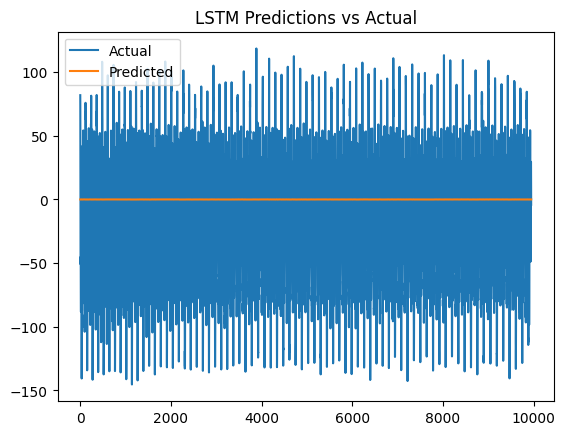

In [49]:
import matplotlib.pyplot as plt

plt.plot(true_vals, label="Actual")
plt.plot(preds, label="Predicted")
plt.legend()
plt.title("LSTM Predictions vs Actual")
plt.show()


In [40]:
outputs, cache = forward_lstm(seq_x, params)


# GRU

In [23]:
def init_gru_params(input_dim, hidden_dim, output_dim):
    def rand_weight(shape):
        return np.random.uniform(-1/np.sqrt(shape[0]), 1/np.sqrt(shape[0]), shape)

    np.random.seed(0)
    return {
        "Wz": rand_weight((input_dim, hidden_dim)),
        "Uz": rand_weight((hidden_dim, hidden_dim)),
        "bz": np.zeros((1, hidden_dim)),

        "Wr": rand_weight((input_dim, hidden_dim)),
        "Ur": rand_weight((hidden_dim, hidden_dim)),
        "br": np.zeros((1, hidden_dim)),

        "Wh": rand_weight((input_dim, hidden_dim)),
        "Uh": rand_weight((hidden_dim, hidden_dim)),
        "bh": np.zeros((1, hidden_dim)),

        "Wy": rand_weight((hidden_dim, output_dim)),
        "by": np.zeros((1, output_dim))
    }


In [24]:
def forward_gru(x_seq, params):
    h_prev = np.zeros((1, params["Uz"].shape[0]))
    outputs = []
    cache = []

    for t in range(len(x_seq)):
        x_t = x_seq[t:t+1]

        z = sigmoid(x_t @ params["Wz"] + h_prev @ params["Uz"] + params["bz"])
        r = sigmoid(x_t @ params["Wr"] + h_prev @ params["Ur"] + params["br"])
        h_tilde = np.tanh(x_t @ params["Wh"] + (r * h_prev) @ params["Uh"] + params["bh"])
        h = (1 - z) * h_prev + z * h_tilde

        y = h @ params["Wy"] + params["by"]

        cache.append((x_t, h_prev, z, r, h_tilde, h))
        h_prev = h
        outputs.append(y)

    return np.vstack(outputs), cache


In [25]:
def backward_gru(dy, cache, params, lr=1e-3):
    grads = {k: np.zeros_like(v) for k, v in params.items()}
    dh_next = np.zeros_like(cache[0][5])

    for t in reversed(range(len(cache))):
        x_t, h_prev, z, r, h_tilde, h = cache[t]

        dy_t = dy[t:t+1]
        grads["Wy"] += h.T @ dy_t
        grads["by"] += dy_t
        dh = dy_t @ params["Wy"].T + dh_next

        dz = dh * (h_tilde - h_prev)
        dh_tilde = dh * z
        dh_prev = dh * (1 - z)

        dz_raw = dz * z * (1 - z)
        dr = ((dh_tilde * (1 - h_tilde**2)) @ params["Uh"].T) * h_prev
        dr_raw = dr * r * (1 - r)

        grads["Wz"] += x_t.T @ dz_raw
        grads["Uz"] += h_prev.T @ dz_raw
        grads["bz"] += dz_raw

        grads["Wr"] += x_t.T @ dr_raw
        grads["Ur"] += h_prev.T @ dr_raw
        grads["br"] += dr_raw

        dh_tilde_raw = dh_tilde * (1 - h_tilde**2)
        grads["Wh"] += x_t.T @ dh_tilde_raw
        grads["Uh"] += (r * h_prev).T @ dh_tilde_raw
        grads["bh"] += dh_tilde_raw

        dh_next = dh_prev + (dh_tilde_raw @ params["Uh"].T) * r + \
                  (dr_raw @ params["Ur"].T) + (dz_raw @ params["Uz"].T)

    for k in params:
        params[k] -= lr * grads[k]

    return params


## Runnning the data

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Replace this with your real DataFrame
data = pd.read_csv("your_data.csv")

# Smooth compass if needed and compute turn speed
# (Skip this if you've already done it)

data['turn_speed-30'] = data['turn_speed'].shift(-30)
data.dropna(inplace=True)

# Normalize only input
scaler = StandardScaler()
data['turn_speed'] = scaler.fit_transform(data[['turn_speed']])

# Extract input and target arrays
PREDICTORS = ['turn_speed']
TARGET = 'turn_speed-30'

train_x = data[PREDICTORS].to_numpy()
train_y = data[[TARGET]].to_numpy()


In [1]:
import numpy as np

# Activation helper functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def init_gru_params(input_dim, hidden_dim, output_dim):
    def rand_weight(shape):
        return np.random.uniform(-1 / np.sqrt(shape[0]), 1 / np.sqrt(shape[0]), shape)

    np.random.seed(0)
    return {
        "Wz": rand_weight((input_dim, hidden_dim)),
        "Uz": rand_weight((hidden_dim, hidden_dim)),
        "bz": np.zeros((1, hidden_dim)),

        "Wr": rand_weight((input_dim, hidden_dim)),
        "Ur": rand_weight((hidden_dim, hidden_dim)),
        "br": np.zeros((1, hidden_dim)),

        "Wh": rand_weight((input_dim, hidden_dim)),
        "Uh": rand_weight((hidden_dim, hidden_dim)),
        "bh": np.zeros((1, hidden_dim)),

        "Wy": rand_weight((hidden_dim, output_dim)),
        "by": np.zeros((1, output_dim))
    }


def forward_gru(x_seq, params):
    h_prev = np.zeros((1, params["Uz"].shape[0]))  # (1, hidden_dim)
    outputs = []
    cache = []

    for t in range(len(x_seq)):
        x_t = x_seq[t:t + 1]  # shape (1, input_dim)

        z = sigmoid(x_t @ params["Wz"] + h_prev @ params["Uz"] + params["bz"])
        r = sigmoid(x_t @ params["Wr"] + h_prev @ params["Ur"] + params["br"])
        h_tilde = np.tanh(x_t @ params["Wh"] + (r * h_prev) @ params["Uh"] + params["bh"])
        h = (1 - z) * h_prev + z * h_tilde

        y = h @ params["Wy"] + params["by"]

        cache.append((x_t, h_prev, z, r, h_tilde, h))
        h_prev = h
        outputs.append(y)

    return np.vstack(outputs), cache


def backward_gru(dy, cache, params, lr=1e-3):
    grads = {k: np.zeros_like(v) for k, v in params.items()}
    dh_next = np.zeros_like(cache[0][5])  # shape (1, hidden_dim)

    for t in reversed(range(len(cache))):
        x_t, h_prev, z, r, h_tilde, h = cache[t]

        dy_t = dy[t:t + 1]
        grads["Wy"] += h.T @ dy_t
        grads["by"] += dy_t
        dh = dy_t @ params["Wy"].T + dh_next

        dz = dh * (h_tilde - h_prev)
        dh_tilde = dh * z
        dh_prev = dh * (1 - z)

        dz_raw = dz * z * (1 - z)
        dr = ((dh_tilde * (1 - h_tilde ** 2)) @ params["Uh"].T) * h_prev
        dr_raw = dr * r * (1 - r)

        grads["Wz"] += x_t.T @ dz_raw
        grads["Uz"] += h_prev.T @ dz_raw
        grads["bz"] += dz_raw

        grads["Wr"] += x_t.T @ dr_raw
        grads["Ur"] += h_prev.T @ dr_raw
        grads["br"] += dr_raw

        dh_tilde_raw = dh_tilde * (1 - h_tilde ** 2)
        grads["Wh"] += x_t.T @ dh_tilde_raw
        grads["Uh"] += (r * h_prev).T @ dh_tilde_raw
        grads["bh"] += dh_tilde_raw

        dh_next = dh_prev + (dh_tilde_raw @ params["Uh"].T) * r + \
                  (dr_raw @ params["Ur"].T) + (dz_raw @ params["Uz"].T)

    for k in params:
        params[k] -= lr * grads[k]

    return params


# ----------------------------
# Run a forward and backward pass with sample data
# ----------------------------

# Parameters
input_dim = 3
hidden_dim = 5
output_dim = 2
seq_length = 4
learning_rate = 1e-3

# Initialize parameters
params = init_gru_params(input_dim, hidden_dim, output_dim)

# Random input sequence (seq_length x input_dim)
np.random.seed(42)
x_seq = np.random.randn(seq_length, input_dim)

print("Input sequence (x_seq):")
print(x_seq)

# Forward pass
outputs, cache = forward_gru(x_seq, params)
print("\nForward pass outputs:")
print(outputs)

# Simulated gradient of loss w.r.t outputs (same shape as outputs)
np.random.seed(24)
dy = np.random.randn(seq_length, output_dim)

print("\nSimulated gradient dy:")
print(dy)

# Backward pass and parameter update
params = backward_gru(dy, cache, params, lr=learning_rate)

print("\nUpdated parameters after backward pass (sample - Wz weights):")
print(params["Wz"])


Input sequence (x_seq):
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]]

Forward pass outputs:
[[-0.06455306 -0.02724663]
 [-0.14502178 -0.07863483]
 [-0.16070323 -0.16675068]
 [-0.10823809 -0.08236682]]

Simulated gradient dy:
[[ 1.32921217 -0.77003345]
 [-0.31628036 -0.99081039]
 [-1.07081626 -1.43871328]
 [ 0.56441685  0.29572189]]

Updated parameters after backward pass (sample - Wz weights):
[[ 0.05634276  0.24841747  0.11862811  0.05178297 -0.08818562]
 [ 0.16845918 -0.07206836  0.45238302  0.53539229 -0.13460845]
 [ 0.33687287  0.03337508  0.07855571  0.49146028 -0.49530092]]
